<a href="https://colab.research.google.com/github/dctian/DeepPiCar/blob/master/models/lane_navigation/code/end_to_end_lane_navigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nvidia Model Driving

## Importing Packages

In [45]:
# status
RunningInCOLAB = 'google.colab' in str(get_ipython())

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle
import math
import re

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
from pandas import read_csv
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model

print(f'tf.__version__: {tf.__version__}')
print(f'keras.__version__: {keras.__version__}')

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


tf.__version__: 2.10.0
keras.__version__: 2.10.0


## Load Train Data

all files purged!
C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-video-10.mp4 C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-key-10.csv
C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-video-17.mp4 C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-key-17.csv
C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-video-2.mp4 C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-key-2.csv
C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-video-40.mp4 C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-key-40.csv
C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-video-42.mp4 C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-key-42.csv
C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-video-46.mp4 C:\Users\User\Desktop\odyssey_nnn\data\dataset\out-key-46.csv
video is empty. nothing to do!
video is empty. nothing to do!
video is empty. nothing to do!
video is empty. nothing to do!
video is empty. nothing to do!
video is empty. nothing to do!
video is empty. nothing to do!
video is em

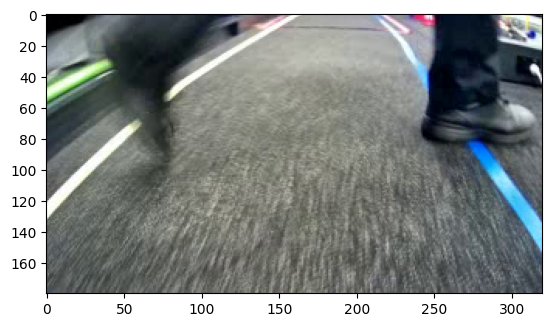

In [46]:
username = 'User'
dataset_dir = f'C:\\Users\\{username}\\Desktop\\odyssey_nnn\\data\\dataset'
extracted_dir = f'C:\\Users\\{username}\\Desktop\\odyssey_nnn\\utils\\notebooks\\extracted'
model_output_dir = f'C:\\Users\\{username}\\Desktop\\odyssey_nnn\\utils\\notebooks\\models'
image_paths = []
steering_angles = []

imgs = []
vals = []
img_width = 320
img_height = 180

import glob
def discriminate():
	extract_iteration = 0
	for vid_file_path in glob.iglob(f'{dataset_dir}\\*.mp4'):
		csv_file_path = vid_file_path.replace('video', 'key').replace('mp4', 'csv') #used to be avi but different encoding now
		print(vid_file_path, csv_file_path)
		
		vid = cv2.VideoCapture(vid_file_path)
		df = read_csv(csv_file_path)
		
		for val in df["wheel"].values:
			ret, img = vid.read()
			if ret is not False:
				extract_iteration += 1
				cv2.imwrite(extracted_dir + "\\" + str(extract_iteration) + "_" + str(val) + ".png", img)
				#steering_angles.append(val)
			else:
				print("video is empty. nothing to do!")
				continue
	print(f"{extract_iteration} iterations.")
	return extract_iteration

def purge():
	files = glob.glob(extracted_dir + "\\*.png")
	for f in files:
		os.remove(f)
	print("all files purged!")

purge()
discriminate()

file_list = os.listdir(extracted_dir)

pattern = "*.png"
for filename in file_list:
	if fnmatch.fnmatch(filename, pattern):
		image_paths.append(os.path.join(extracted_dir, filename))
		angle = re.search(r"[-+]?\d+\.\d+", filename).group()
		steering_angles.append(float(angle))
		#angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
		#steering_angles.append(angle)

image_index = 40
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print(f"steering radians: {steering_angles[image_index]}")
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles


(array([17.0000, 6.0000, 24.0000, 18.0000, 117.0000, 17.0000, 84.0000,
        196.0000, 225.0000, 161.0000, 410.0000, 1376.0000, 669.0000,
        338.0000, 289.0000, 302.0000, 152.0000, 32.0000, 119.0000, 44.0000,
        23.0000, 9.0000, 25.0000, 1.0000, 5.0000]),
 array([-0.8901, -0.8126, -0.7351, -0.6576, -0.5801, -0.5027, -0.4252,
        -0.3477, -0.2702, -0.1927, -0.1152, -0.0377, 0.0398, 0.1173,
        0.1948, 0.2723, 0.3498, 0.4273, 0.5047, 0.5822, 0.6597, 0.7372,
        0.8147, 0.8922, 0.9697, 1.0472]),
 <BarContainer object of 25 artists>)

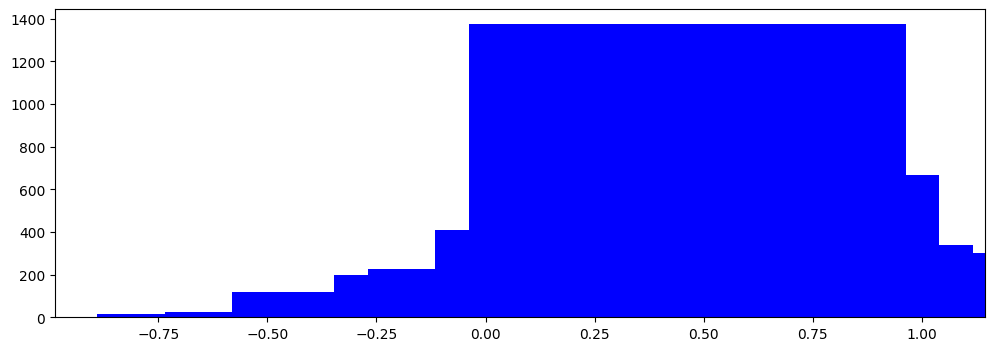

In [47]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Training data: 3727
Validation data: 932


Text(0.5, 1.0, 'Validation Data')

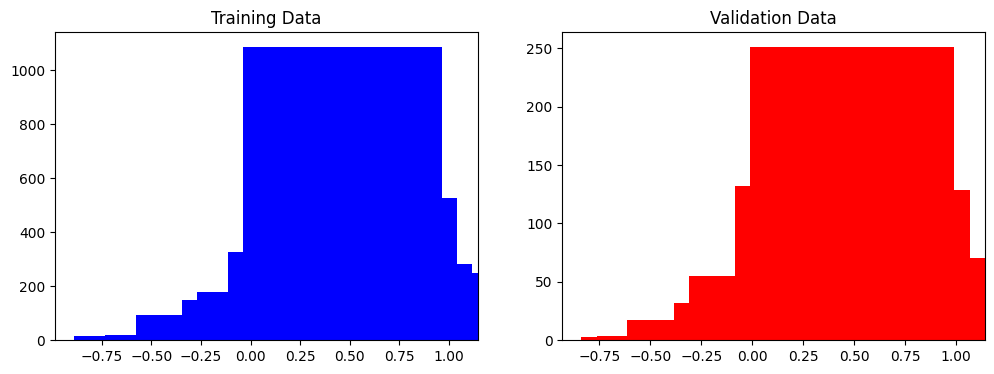

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')


## Image Augmentation

Text(0.5, 1.0, 'zoomed')

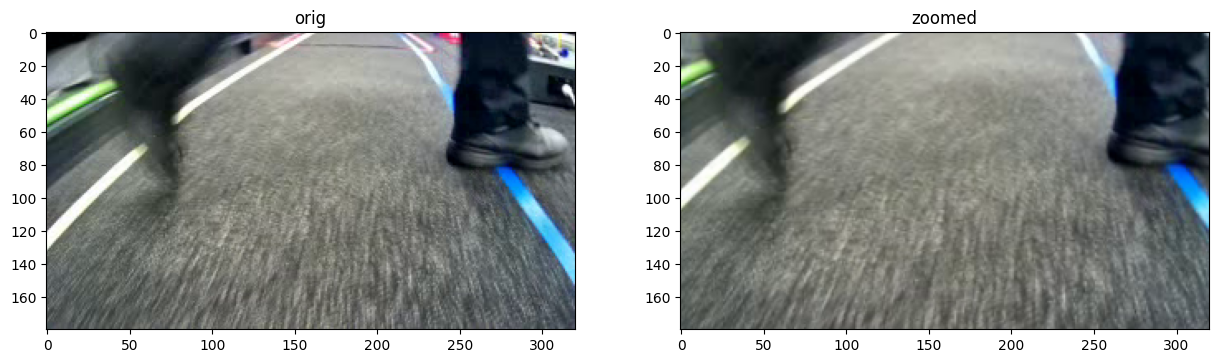

In [49]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")


Text(0.5, 1.0, 'panned')

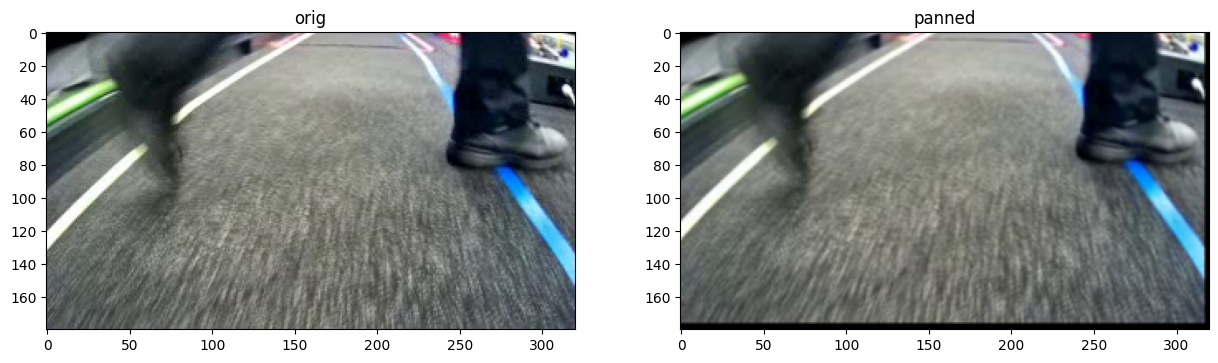

In [50]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")


Text(0.5, 1.0, 'brightness adjusted')

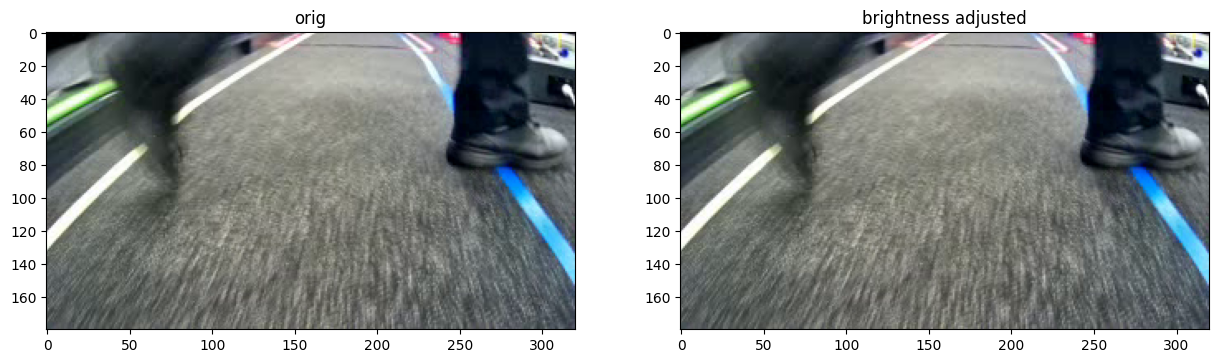

In [51]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

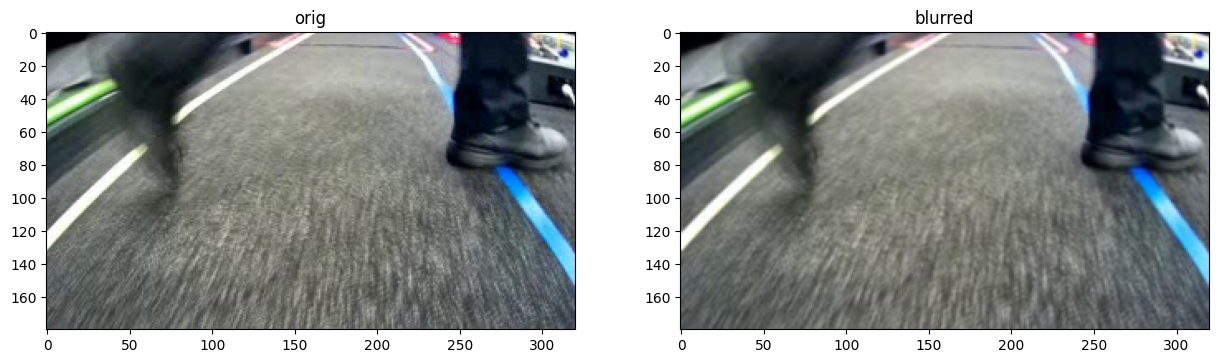

In [52]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, angle=0.1745329251994329')

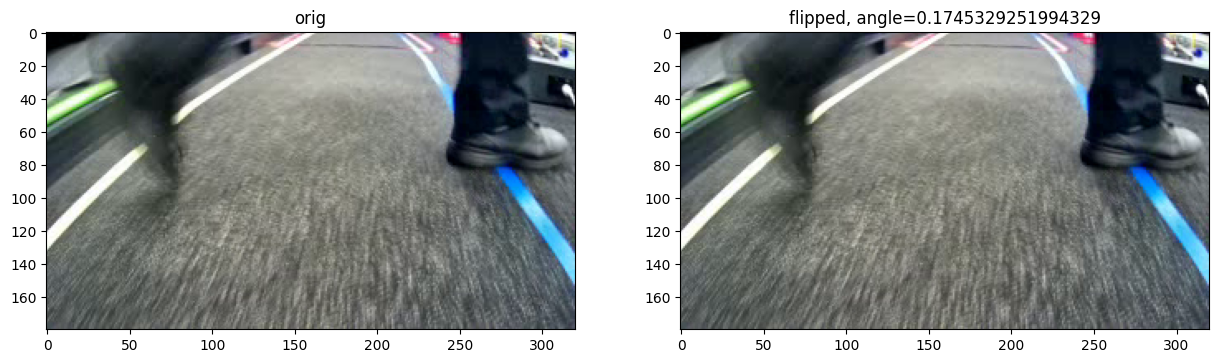

In [53]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        #steering_angle = 180 - steering_angle
        steering_angle = -1 * steering_angle

    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

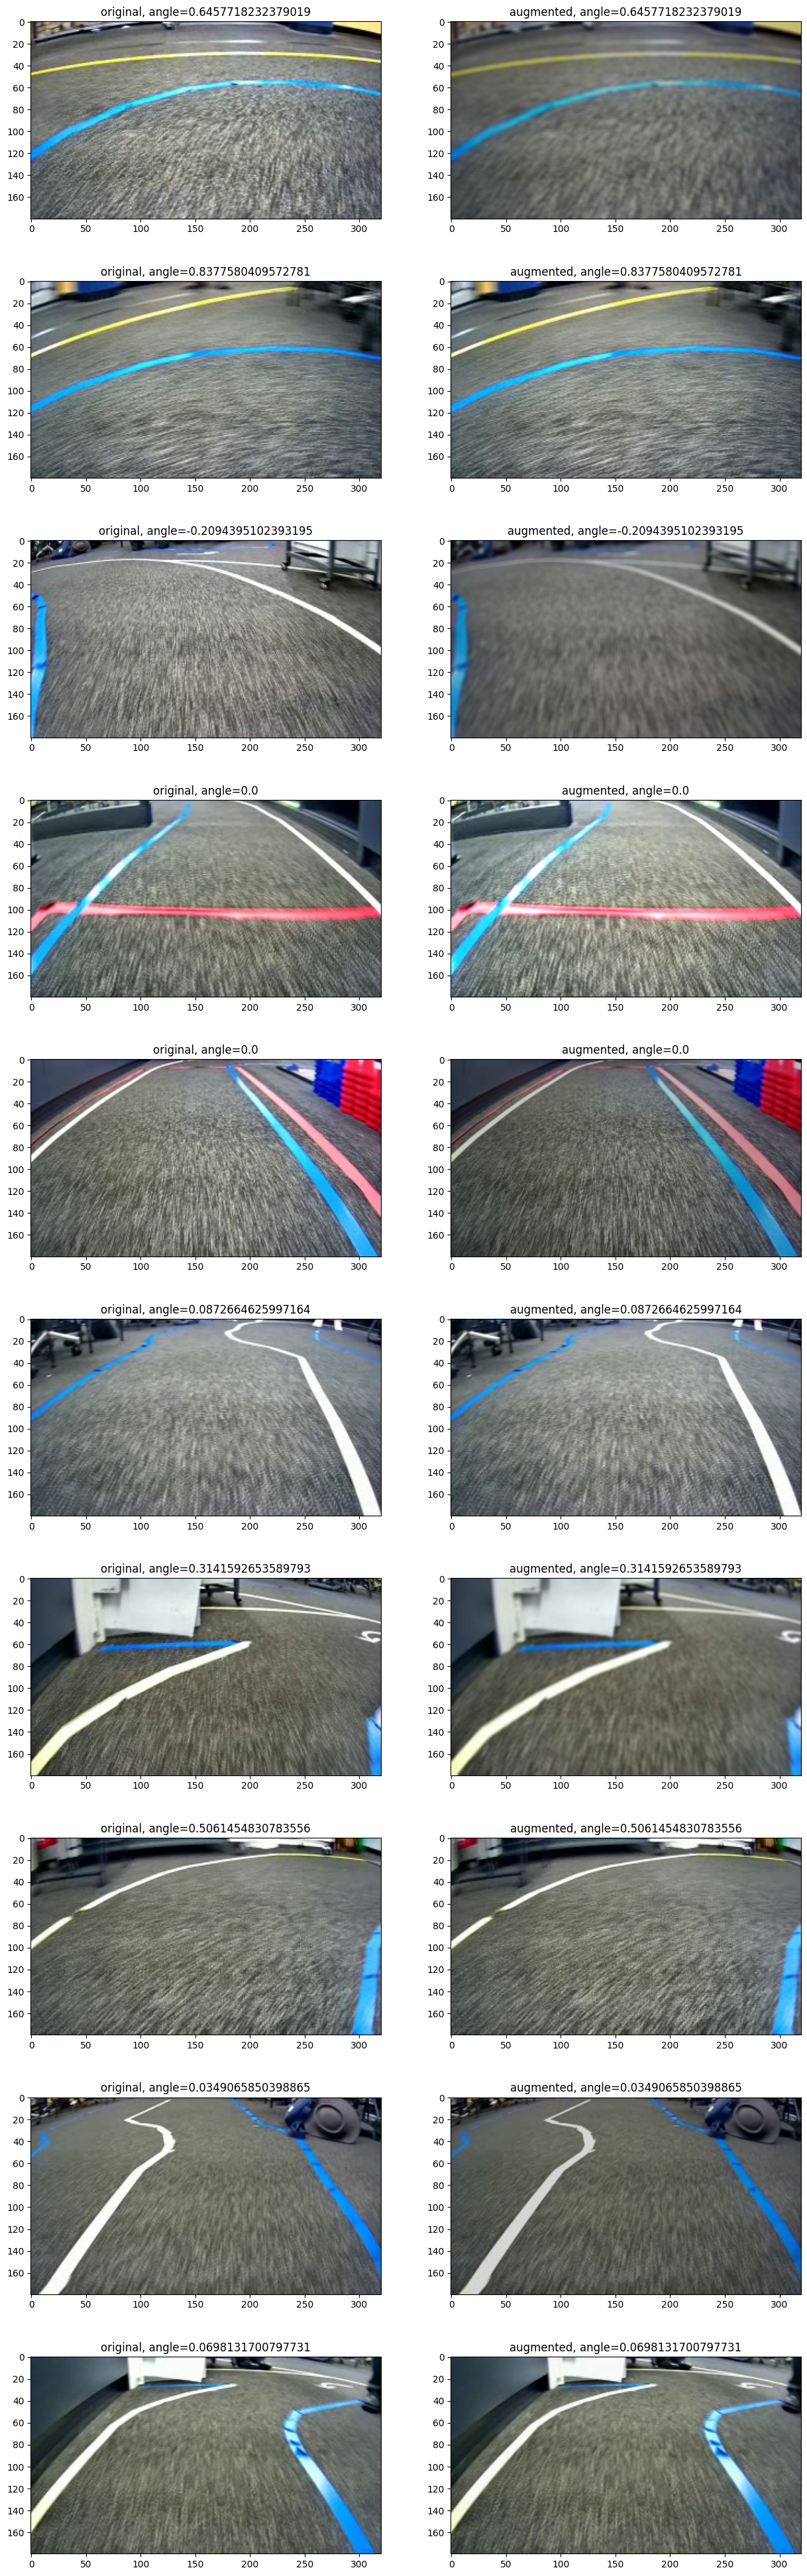

In [62]:
# put it together
def random_augment(image, steering_angle):
	if np.random.rand() < 0.5:
		#image = pan(image)
		pass
	if np.random.rand() < 0.5:
		#image = zoom(image)
		pass
	if np.random.rand() < 0.5:
		image = blur(image)
	if np.random.rand() < 0.5:
		image = adjust_brightness(image)
	#image, steering_angle = random_flip(image, steering_angle) # flip seems to screw up data
	
	return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 10
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
	rand_index = random.randint(0, len(image_paths) - 1)
	image_path = image_paths[rand_index]
	steering_angle_orig = steering_angles[rand_index]
	
	image_orig = my_imread(image_path)
	image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
	
	axes[i][0].imshow(image_orig)
	axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
	axes[i][1].imshow(image_aug)
	axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)
    

## Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

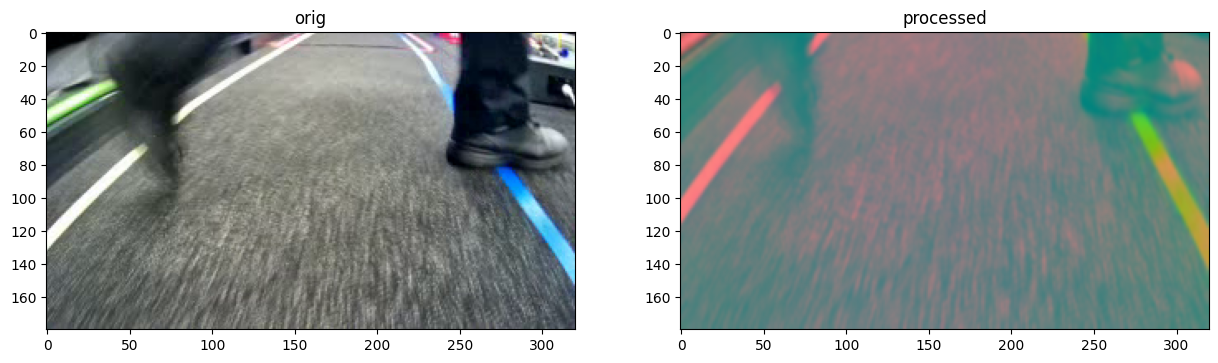

In [63]:
def img_preprocess(image):
    height, _, _ = image.shape
    image = image[int(height/4):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (img_width, img_height)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")


## Create and Train Model

In [70]:
def nvidia_model():
	model = Sequential(name='Nvidia_Model')
	
	# elu=Expenential Linear Unit, similar to leaky Relu
	# skipping 1st hidden layer (normalization layer), as we have normalized the data
	
	# Convolution Layers
	model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(img_height, img_width, 3), activation='elu')) 
	model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
	model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
	model.add(Conv2D(64, (3, 3), activation='elu')) 
	model.add(Dropout(0.2)) # not in original model. added for more robustness
	model.add(Conv2D(64, (3, 3), activation='elu')) 
	
	# Fully Connected Layers
	model.add(Flatten())
	model.add(Dropout(0.2)) # not in original model. added for more robustness
	model.add(Dense(100, activation='elu'))
	model.add(Dense(50, activation='elu'))
	model.add(Dense(10, activation='elu'))
	
	# output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
	model.add(Dense(1)) 
	
	# since this is a regression problem not classification problem,
	# we use MSE (Mean Squared Error) as loss function
	optimizer = Adam(lr=1e-3) # lr is learning rate
	model.compile(loss='mse', optimizer=optimizer)
	
	return model

def original_model():
	# original model
	model = tf.keras.Sequential()
	model.add(Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(img_height, img_width, 3)))
	model.add(Conv2D(36, (5,5), strides=(2,2), activation='relu'))
	model.add(Conv2D(48, (5,5), strides=(2,2), activation='relu'))
	model.add(Conv2D(64, (3,3), activation='relu'))
	model.add(Conv2D(64, (3,3), activation='relu'))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(50, activation='relu'))
	model.add(Dense(10, activation='relu'))
	model.add(Dense(1, name="output"))
	
	print("Compiling model...")
	
	model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
		            loss=tf.keras.losses.MeanSquaredError())
	
	return model


#model = nvidia_model()
model = original_model()
print(model.summary())

Compiling model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 88, 158, 24)       1824      
                                                                 
 conv2d_16 (Conv2D)          (None, 42, 77, 36)        21636     
                                                                 
 conv2d_17 (Conv2D)          (None, 19, 37, 48)        43248     
                                                                 
 conv2d_18 (Conv2D)          (None, 17, 35, 64)        27712     
                                                                 
 conv2d_19 (Conv2D)          (None, 15, 33, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 31680)             0         
                                                                 
 dense_9 (Dense)             (None,

In [72]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training):
	while True:
		batch_images = []
		batch_steering_angles = []
		
		for i in range(batch_size):
			random_index = random.randint(0, len(image_paths) - 1)
			image_path = image_paths[random_index]
			image = my_imread(image_paths[random_index])
			steering_angle = steering_angles[random_index]
			if is_training:
				# training: augment image
				image, steering_angle = random_augment(image, steering_angle)

			image = img_preprocess(image)
			batch_images.append(image)
			batch_steering_angles.append(steering_angle)
				
		yield(np.asarray(batch_images), np.asarray(batch_steering_angles))
            
            

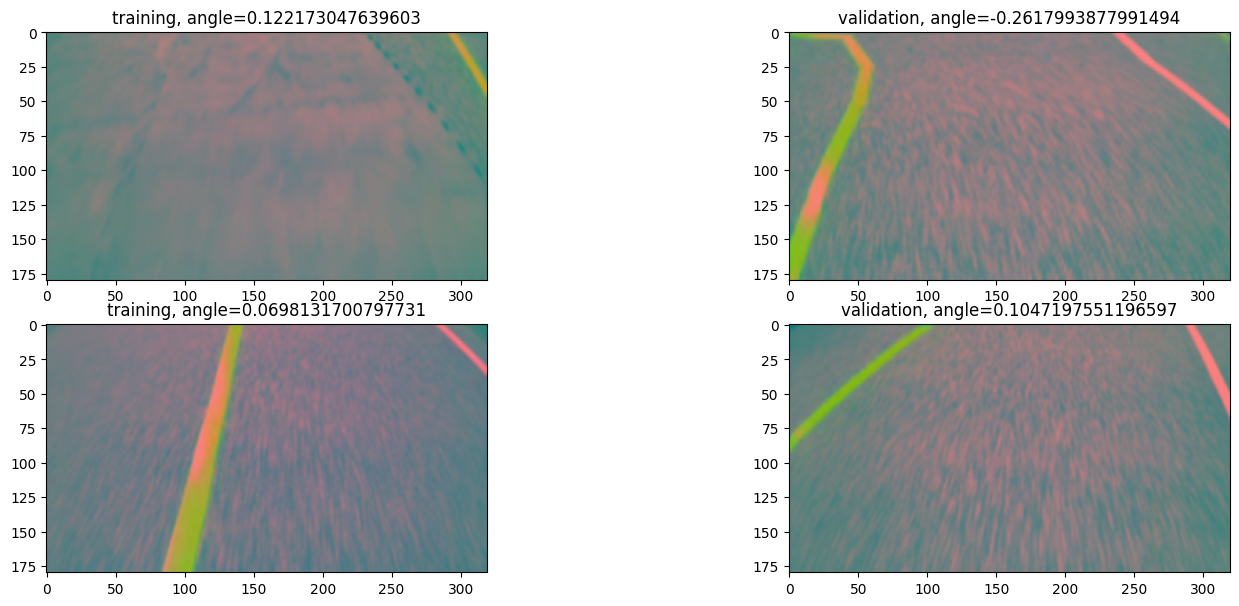

In [73]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])


In [74]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}\\logs\\'
#!rm -rf $log_dir_root


In [ ]:
# this block prevents the training from starting if we Run All
DO_NOT_RUN_ALL

In [75]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

history = model.fit(image_data_generator( X_train, y_train, batch_size=100, is_training=True),
										steps_per_epoch=300,
										epochs=10,
										validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
										validation_steps=200,
										verbose=1,
										shuffle=1,
										callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
  pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
  
print("Model training complete!")


Epoch 1/10
300/300 [==============================] - ETA: 0s - loss: 0.0283
Epoch 1: val_loss improved from inf to 0.01247, saving model to C:\Users\User\Desktop\odyssey_nnn\utils\notebooks\models\lane_navigation_check.h5
300/300 [==============================] - 117s 389ms/step - loss: 0.0283 - val_loss: 0.0125
Epoch 2/10
300/300 [==============================] - ETA: 0s - loss: 0.0066
Epoch 2: val_loss improved from 0.01247 to 0.00705, saving model to C:\Users\User\Desktop\odyssey_nnn\utils\notebooks\models\lane_navigation_check.h5
300/300 [==============================] - 118s 394ms/step - loss: 0.0066 - val_loss: 0.0070
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 0.0029
Epoch 3: val_loss improved from 0.00705 to 0.00621, saving model to C:\Users\User\Desktop\odyssey_nnn\utils\notebooks\models\lane_navigation_check.h5
300/300 [==============================] - 119s 398ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 4/10
300/300 [========================

## Check Trained Model on Validation Data

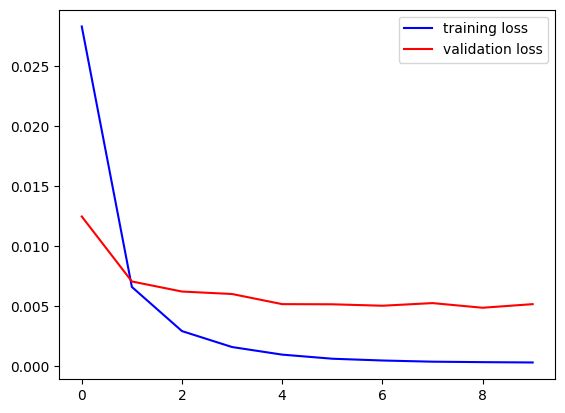

In [76]:
history.history

# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])


In [77]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred
		
def rad2deg(rad):
	return 180.0 * rad / math.pi

4/4 [==============================] - 1s 23ms/step
mse       = 0.0025
r_squared = 95.70%



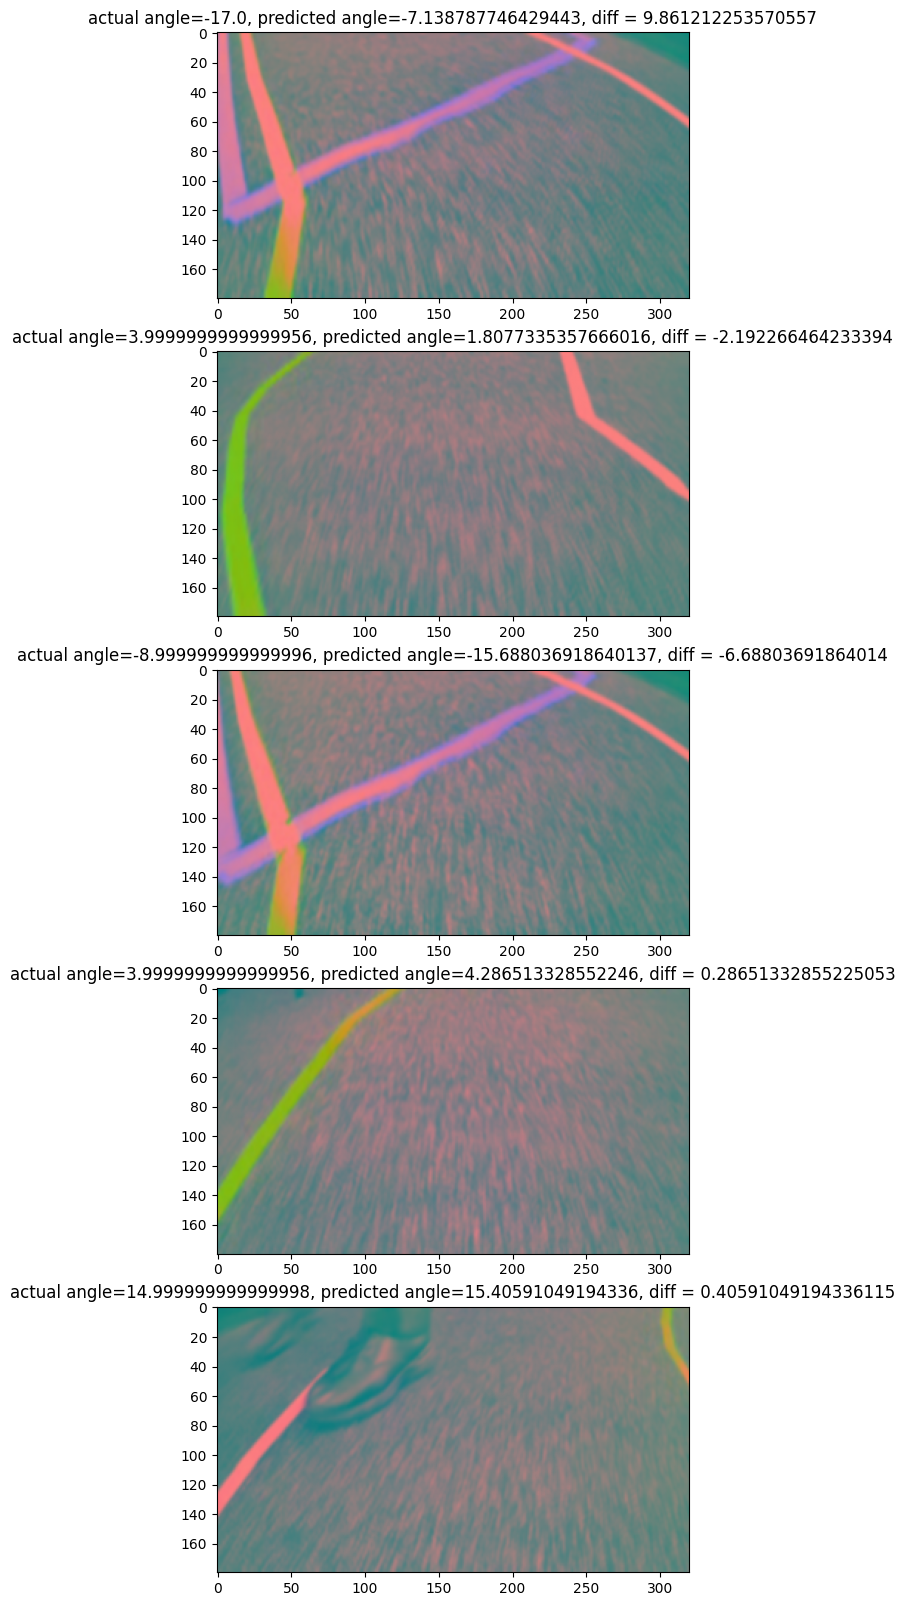

In [78]:
n_tests = 43
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 5
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={rad2deg(y_test[i])}, predicted angle={float(rad2deg(y_pred[i]))}, diff = {float(rad2deg(y_pred[i]))-rad2deg(y_test[i])}")
    

## Save Model

In [79]:
# save the tflite model, as robot can't run h5
print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

with open(model_output_dir + "\\opt" + ".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

if RunningInCOLAB: 
    from google.colab import files
    files.download(model_file+".tflite")

TFLite Model


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpb6wz5fw2\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpb6wz5fw2\assets


input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [ ]:
DO_NOT_RUN_ALL

## Collect the Garbage

In [ ]:
import gc
gc.collect()

from keras import backend as k_backend
k_backend.clear_session()